In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transforms for the training and validation sets
transform = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize images to 512x512
    transforms.ToTensor(),  # Convert images to PyTorch tensors
])

# Load the datasets
train_dataset = datasets.ImageFolder(root="D:/datasets/DL/Food/training", transform=transform)
validation_dataset = datasets.ImageFolder(root='D:/datasets/DL/Food/validation', transform=transform)
evaluation_dataset = datasets.ImageFolder(root='D:/datasets/DL/Food/evaluation', transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)
evaluation_loader = DataLoader(evaluation_dataset, batch_size=32, shuffle=False)


In [2]:
import torch.nn as nn
import torch.nn.functional as F

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 64 * 64, 128)  # Adjust based on image size
        self.fc2 = nn.Linear(128, len(train_dataset.classes))  # Output layer

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 64 * 64)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model
model = CNNModel()

# Check if CUDA is available and move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=524288, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=11, bias=True)
)

In [3]:
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [4]:
from tqdm import tqdm


num_epochs = 10  # Adjust based on your needs

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    # Use tqdm to show progress for the training loop
    for images, labels in tqdm(train_loader, desc=f'Epoch [{epoch + 1}/{num_epochs}]', leave=False):
        images, labels = images.to(device), labels.to(device)  # Move to GPU if available

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')


Epoch [1/10], Loss: 2.2691


Epoch [2/10], Loss: 2.0512


Epoch [3/10], Loss: 1.8610


Epoch [4/10], Loss: 1.6331


Epoch [5/10], Loss: 1.2624


Epoch [6/10], Loss: 0.8029


Epoch [7/10], Loss: 0.4354


Epoch [8/10], Loss: 0.2296


Epoch [9/10], Loss: 0.1139


Epoch [10/10], Loss: 0.1017


In [5]:
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0

with torch.no_grad():  # Disable gradient tracking
    # Use tqdm to show progress for the evaluation loop
    for images, labels in tqdm(evaluation_loader, desc='Evaluating', leave=False):
        images, labels = images.to(device), labels.to(device)  # Move to GPU if available
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Evaluation accuracy: {100 * correct / total:.2f}%')


Evaluation accuracy: 32.78%


In [6]:
import numpy as np
import torch
from torchvision import transforms
from PIL import Image

# Define a function to preprocess the image data
def preprocess_image_data(image_data):
    transform = transforms.Compose([
        transforms.Resize((512, 512)),  # Resize images to 512x512
        transforms.ToTensor(),  # Convert images to PyTorch tensors
    ])

    # Apply the transformation
    image = transform(Image.fromarray(image_data)).unsqueeze(0)  # Add batch dimension
    return image.to(device)  # Move to GPU if available

# Example: Create random image arrays (for demonstration)
# Replace this with your actual images
image_data_list = [np.random.rand(512, 512, 3) * 255 for _ in range(5)]
image_data_list = [img.astype(np.uint8) for img in image_data_list]  # Convert to uint8

# Make predictions for each image
predicted_classes = []
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient tracking
    for image_data in image_data_list:
        image = preprocess_image_data(image_data)  # Preprocess the image
        output = model(image)  # Forward pass
        _, predicted = torch.max(output.data, 1)  # Get predicted class
        predicted_classes.append(train_dataset.classes[predicted.item()])  # Store predicted class

# Print predicted classes for all images
for i, predicted_class in enumerate(predicted_classes):
    print(f'Predicted class for image {i + 1}: {predicted_class}')


Predicted class for image 1: Soup
Predicted class for image 2: Soup
Predicted class for image 3: Soup
Predicted class for image 4: Bread
Predicted class for image 5: Bread


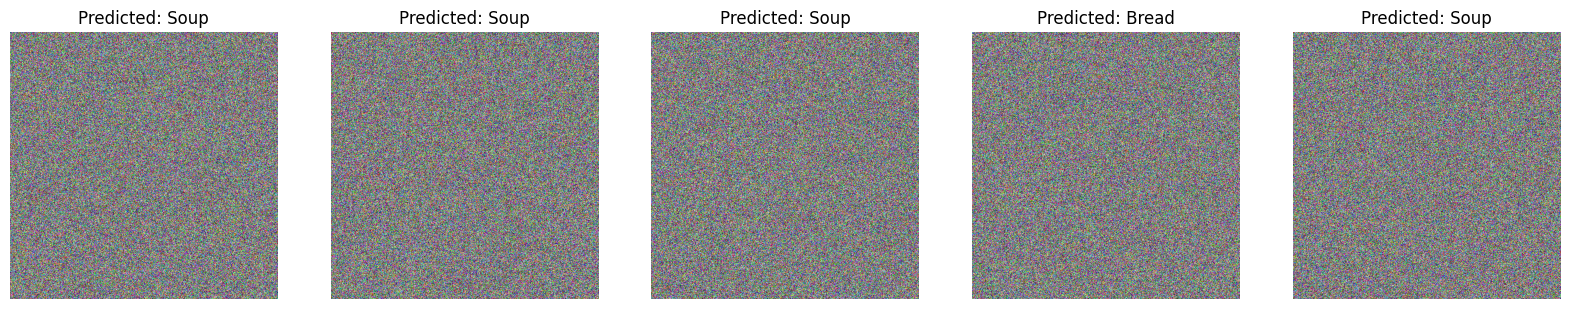

In [7]:
import numpy as np
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Define a function to preprocess the image data
def preprocess_image_data(image_data):
    transform = transforms.Compose([
        transforms.Resize((512, 512)),  # Resize images to 512x512
        transforms.ToTensor(),  # Convert images to PyTorch tensors
    ])

    # Apply the transformation
    image = transform(Image.fromarray(image_data)).unsqueeze(0)  # Add batch dimension
    return image.to(device)  # Move to GPU if available

# Example: Create random image arrays (for demonstration)
# Replace this with your actual images
image_data_list = [np.random.rand(512, 512, 3) * 255 for _ in range(5)]
image_data_list = [img.astype(np.uint8) for img in image_data_list]  # Convert to uint8

# Make predictions for each image
predicted_classes = []
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient tracking
    for image_data in image_data_list:
        image = preprocess_image_data(image_data)  # Preprocess the image
        output = model(image)  # Forward pass
        _, predicted = torch.max(output.data, 1)  # Get predicted class
        predicted_classes.append(train_dataset.classes[predicted.item()])  # Store predicted class

# Plot the images and their predicted classes
fig, axs = plt.subplots(1, 5, figsize=(20, 5))  # Create a subplot for 5 images
for i, image_data in enumerate(image_data_list):
    axs[i].imshow(image_data.astype(np.uint8))  # Display the original image
    axs[i].set_title(f'Predicted: {predicted_classes[i]}')  # Set title with prediction
    axs[i].axis('off')  # Turn off axis labels

plt.show()  # Display the plot


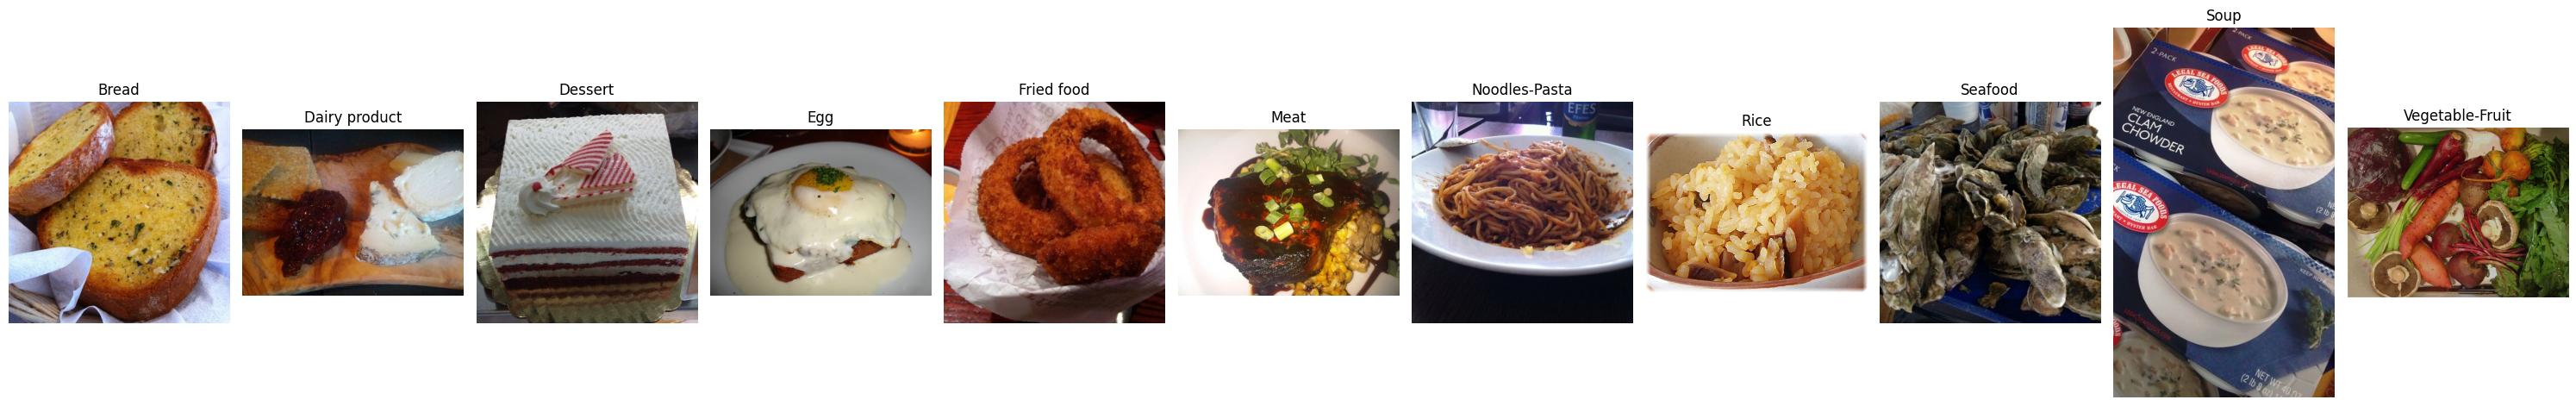

In [7]:
import matplotlib.pyplot as plt
import os
from PIL import Image

# Define the directory containing your dataset
data_dir = 'D:/datasets/DL/Food/training'  # Change this to your training data directory

# Get the list of class directories
class_names = os.listdir(data_dir)

# Create a figure to display one image from each class
fig, axs = plt.subplots(1, len(class_names), figsize=(30, 5))  # Create a subplot for each class

# Loop through each class and display one sample image
for i, class_name in enumerate(class_names):
    # Get the path to the class directory
    class_dir = os.path.join(data_dir, class_name)

    # Get the first image file in the class directory
    image_files = os.listdir(class_dir)
    if image_files:
        sample_image_path = os.path.join(class_dir, image_files[0])  # Get the first image path
        sample_image = Image.open(sample_image_path)  # Open the image

        axs[i].imshow(sample_image)  # Display the image
        axs[i].axis('off')  # Turn off axis
        axs[i].set_title(class_name)  # Set title as class name

plt.tight_layout()  # Adjust layout
plt.show()  # Display the plot
